In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
#!pip install graphviz --quiet
#!pip install micrograd --quiet

In [3]:
from graphviz import Digraph
from micrograd.engine import Value

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [192]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other
    
    

# Derivative of out by self
dOut/dSelf = (f(x+h) - f(x))/h = ((self + h)*other - self * other)/h = other

# Derivative of out by other
dOut/dOther = (f(x+h) - f(x))/h = (self*(other+h) - self * other)/h = self

In [193]:
#Forward pass
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

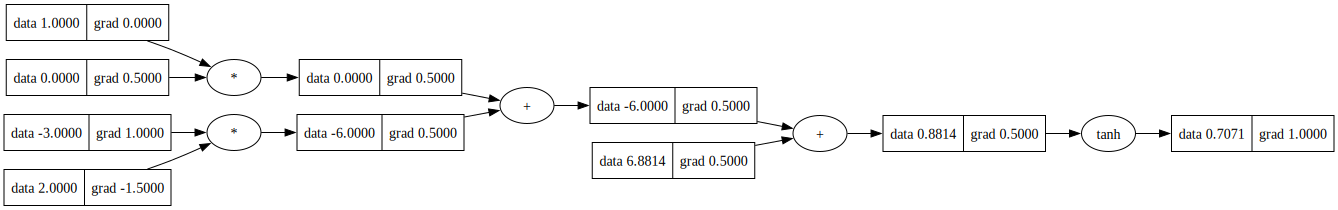

In [194]:
draw_dot(o)

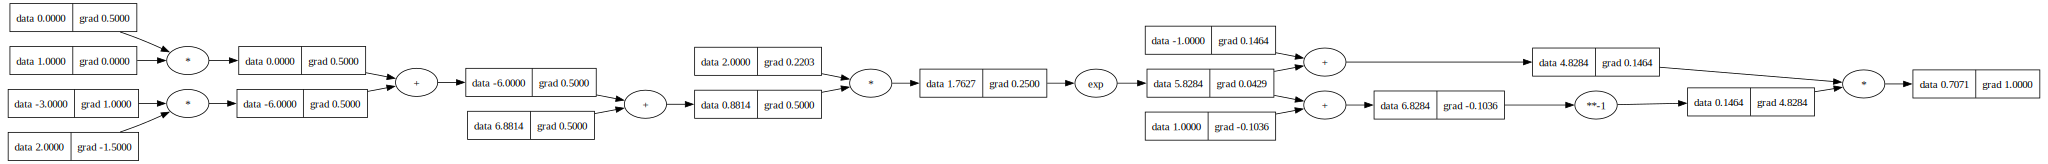

In [195]:
#Forward pass
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp()
o = (e - 1)/(e + 1)
#-----
o.label = 'o'
o.backward()
draw_dot(o)

In [196]:
import torch

In [197]:
x1 = torch.Tensor([2.0]).double()   ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).requires_grad_(True).double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item()) 
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [198]:
import random

In [215]:
class Neuron:
    def __init__(self, n_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))
        print('neuron')
    
    #Forward pass
    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # Raw Activation
        out = activation.tanh() # Non-linear activation
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_inputs, n_outputs):
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
        print('layer')
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, n_inputs, n_outputs):
        sz = [n_inputs] + n_outputs
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outputs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [216]:
x = [0.2, 3.0]
n = Neuron(2)
print('One Neuron: ', n(x)) # n(x) calls the __call__ method of class

n = Layer(2, 3)
print('One Layer with 3 Neurons of 2 diminensions: ', n(x))

x = [0.2, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
print('One Multi layer with 3 inputs and two layers of 4 Neurons with on output: ', n(x))

neuron
One Neuron:  Value(data=-0.886894934783537)
neuron
neuron
neuron
layer
One Layer with 3 Neurons of 2 diminensions:  [Value(data=0.8148169828020928), Value(data=0.2295656480118276), Value(data=-0.99123983404273)]
[3, 4, 4, 1]
neuron
neuron
neuron
neuron
layer
neuron
neuron
neuron
neuron
layer
neuron
layer
One Multi layer with 3 inputs and two layers of 4 Neurons with on output:  Value(data=-0.2027988214195281)


In [298]:
n.parameters()

[Value(data=-0.6392075436929189),
 Value(data=-0.7334585799778516),
 Value(data=1.1826467835674483),
 Value(data=0.3408220512716311),
 Value(data=-0.06397073865354636),
 Value(data=0.24744363991381008),
 Value(data=-0.05743401897562633),
 Value(data=1.3779844804240884),
 Value(data=-1.0141856614022242),
 Value(data=0.8011723132013554),
 Value(data=-0.23856280524834828),
 Value(data=1.0464764259395902),
 Value(data=0.5309154631367538),
 Value(data=0.5986399043718745),
 Value(data=-1.6722517591651882),
 Value(data=-0.9083228555564398),
 Value(data=0.07160880151081672),
 Value(data=0.5242379555648654),
 Value(data=0.4963108125286554),
 Value(data=-1.3885134061633317),
 Value(data=-0.5528848193962967),
 Value(data=-0.940077056608649),
 Value(data=1.0455234548562247),
 Value(data=0.05551050875596997),
 Value(data=-0.4030042304729766),
 Value(data=0.7189240608549989),
 Value(data=0.29805612699021294),
 Value(data=0.2685844696294582),
 Value(data=-0.6840659191102094),
 Value(data=-1.094054194

In [ ]:
draw_dot(n(x))

In [380]:
x = [0.2, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[3, 4, 4, 1]
neuron
neuron
neuron
neuron
layer
neuron
neuron
neuron
neuron
layer
neuron
layer


Value(data=-0.8218893786661418)

In [381]:
xs = [
  [0.2, 3.0, -1.0],
  [0.1, 0.3, 0.5],
  [0.0, -1.0, 0.0],
  [1.0, 0.0, 0.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [382]:
ypred = [n(x) for x in xs]
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=7.163298271237344)

In [398]:
for k in range(20):
  # Forward pass
  ypred = [n(x) for x in xs] # predictions
  # Validate the loss
  loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))

  #Zero the gradients
  for p in n.parameters():
    p.grad = 0.0
  #Backward pass
  loss.backward()

  # Updated gradients
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 0.005874079691979008
1 0.005833347919590229
2 0.005793155295538472
3 0.005753491340614415
4 0.0057143458433249125
5 0.005675708851439943
6 0.005637570663856769
7 0.005599921822767533
8 0.005562753106117023
9 0.005526055520338493
10 0.005489820293355499
11 0.005454038867838419
12 0.0054187028947050445
13 0.005383804226855053
14 0.005349334913128504
15 0.0053152871924792055
16 0.005281653488354059
17 0.005248426403269899
18 0.005215598713579996
19 0.005183163364422317


In [399]:
ypred

[Value(data=0.9659477780723317),
 Value(data=-0.9622865520229198),
 Value(data=-0.9734650863983482),
 Value(data=0.9564430975843773)]